In [7]:
import sys
from datetime import datetime

import gymnasium as gym
import numpy as np
import wandb
from stable_baselines3 import *
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.logger import HumanOutputFormat
from stable_baselines3.common.logger import Logger as SB3Logger

import sinergym
from sinergym.utils.callbacks import *
from sinergym.utils.constants import *
from sinergym.utils.logger import WandBOutputFormat
from sinergym.utils.rewards import *
from sinergym.utils.wrappers import *

In [8]:
from stable_baselines3.common.env_util import make_vec_env

In [9]:
# Environment ID
environment = 'Eplus-5zone-mixed-continuous-stochastic-v1'

# Training episodes
episodes = 50

# Name of the experiment
experiment_date = datetime.today().strftime('%Y-%m-%d_%H:%M')
experiment_name = '5Z_LONG_SB3_PPO-' + environment + \
    '-episodes-' + str(episodes)
experiment_name += '_' + experiment_date

In [10]:
extra_conf = {
    'timesteps_per_hour': 6,
    'runperiod': (1, 4, 2024, 1, 3, 2025),
}

In [11]:
env = gym.make(environment,
               env_name=experiment_name,
               weather_files=["JPN_Nagoya.476350_IWEC.epw"],
               reward=ExpReward,
               reward_kwargs = {
                   "energy_weight": 0.5,
                   'temperature_variables': ['air_temperature'],
                   'energy_variables': ['HVAC_electricity_demand_rate'],
                   "range_comfort_winter": (18.0, 28.0),
                   "range_comfort_summer": (18.0, 28.0),
                   "lambda_energy": 0.0001,
               },
              building_config=extra_conf,)

eval_env = gym.make(environment,
                    env_name=experiment_name+'_EVALUATION',
                    weather_files=["JPN_Nagoya.476350_IWEC.epw"],
                    reward=ExpReward,
                    reward_kwargs = {
                        "energy_weight": 0.5,
                        'temperature_variables': ['air_temperature'],
                        'energy_variables': ['HVAC_electricity_demand_rate'],
                        "range_comfort_winter": (18.0, 28.0),
                        "range_comfort_summer": (18.0, 28.0),
                        "lambda_energy": 0.0001,
                    },
                   building_config=extra_conf,)

#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.                           
[ENVIRONMENT] (INFO) : Name: 5Z_LONG_SB3_PPO-Eplus-5zone-mixed-continuous-stochastic-v1-episodes-50_2025-08-14_14:37
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspace/5Z_LONG_SB3_PPO-Eplus-5zone-mixed-continuous-stochastic-v1-episodes-50_2025-08-14_14:37-res1
[MODEL] (INFO) : Model Config is correct.                                        
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.           
[MODEL] (INFO) : Building configuration: runperiod updated to {'start_day': 1, 'start_month': 4, 'start_year': 2024, 'end_day': 1, 'end_month': 3, 'end_year': 2025, 'start_weekday': 1, 'n_steps_per_hour': 6}
[M

In [12]:
env = NormalizeObservation(env)
env = NormalizeAction(env)
env = LoggerWrapper(env)
env = CSVLogger(env)

eval_env = NormalizeObservation(eval_env)
eval_env = NormalizeAction(eval_env)
eval_env = LoggerWrapper(eval_env)
eval_env = CSVLogger(eval_env)

# In this case, all the hyperparameters are the default ones
model = PPO(
    'MlpPolicy',
    env,
    verbose=1,
    device='cpu',
    learning_rate=0.0003,
    gamma=0.9,
    batch_size=128,
    max_grad_norm=0.9,
    ent_coef=0,
)

callbacks = []

# Set up Evaluation logging and saving best model
eval_callback = LoggerEvalCallback(
    eval_env=eval_env,
    train_env=env,
    n_eval_episodes=2,
    eval_freq_episodes=5,
    deterministic=True)

callbacks.append(eval_callback)
callback = CallbackList(callbacks)

timesteps = episodes * (env.get_wrapper_attr('timestep_per_episode') - 1)

model.learn(
    total_timesteps=timesteps,
    callback=callback,
    log_interval=100)

[WRAPPER NormalizeObservation] (INFO) : Wrapper initialized.                     
[WRAPPER NormalizeAction] (INFO) : New normalized action space: Box(-1.0, 1.0, (2,), float32)
[WRAPPER NormalizeAction] (INFO) : Wrapper initialized.                          
[WRAPPER LoggerWrapper] (INFO) : Wrapper initialized.                            
[WRAPPER CSVLogger] (INFO) : Wrapper initialized.                                
[WRAPPER NormalizeObservation] (INFO) : Wrapper initialized.                     
[WRAPPER NormalizeAction] (INFO) : New normalized action space: Box(-1.0, 1.0, (2,), float32)
[WRAPPER NormalizeAction] (INFO) : Wrapper initialized.                          
[WRAPPER LoggerWrapper] (INFO) : Wrapper initialized.                            
[WRAPPER CSVLogger] (INFO) : Wrapper initialized.                                
Simulation Progress [Episode 4]:   9%|▉         | 9/100 [00:24<00:56,  1.62%/s, 9% completed]Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrap

Simulation Progress [Episode 61]:   2%|▏         | 2/100 [00:19<00:06, 14.52%/s, 2% completed]

In [13]:
env.close()
eval_env.close()

[WRAPPER CSVLogger] (INFO) : Environment closed, data updated in monitor and progress.csv.
[WRAPPER NormalizeObservation] (INFO) : Normalization calibration saved.           
Simulation Progress [Episode 61]:   2%|▏         | 2/100 [00:59<48:48, 29.89s/%, 2% completed]]
[ENVIRONMENT] (INFO) : Environment closed. [5Z_LONG_SB3_PPO-Eplus-5zone-mixed-continuous-stochastic-v1-episodes-50_2025-08-14_14:37]
[WRAPPER CSVLogger] (INFO) : Environment closed, data updated in monitor and progress.csv.
[WRAPPER NormalizeObservation] (INFO) : Normalization calibration saved.           
[ENVIRONMENT] (INFO) : Environment closed. [5Z_LONG_SB3_PPO-Eplus-5zone-mixed-continuous-stochastic-v1-episodes-50_2025-08-14_14:37_EVALUATION]
Simulation Progress [Episode 4]:   9%|▉         | 9/100 [1:03:58<00:56,  1.62%/s, 9% completed]

In [3]:
import matplotlib.pyplot as plt
import csv
import numpy as np

In [4]:
with open("5Z_LONG_SB3_PPO-Eplus-5zone-mixed-continuous-stochastic-v1-episodes-50_2025-08-14_14:37-res1/progress.csv") as f:
    reader = csv.DictReader(f)
    mean_rewards = []
    mean_comforts = []
    mean_energys = []
    for row in reader:
        mean_rewards.append(float(row["mean_reward"]))
        mean_comforts.append(float(row["mean_reward_comfort_term"]))
        mean_energys.append(float(row["mean_reward_energy_term"]))

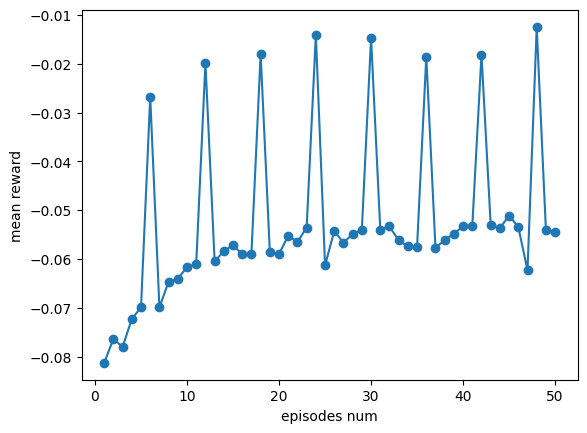

In [5]:
episodes = 50
plt.plot(np.arange(1,episodes+1,1), mean_rewards[:episodes], marker="o")
plt.xlabel("episodes num")
plt.ylabel("mean reward")
plt.show()

In [6]:
with open("5Z_LONG_SB3_PPO-Eplus-5zone-mixed-continuous-stochastic-v1-episodes-50_2025-08-14_14:37-res1/evaluation/evaluation_metrics.csv") as f:
    reader = csv.DictReader(f)
    mean_rewards = []
    mean_comforts = []
    mean_energys = []
    for row in reader:
        mean_rewards.append(float(row["mean_reward"]))
        mean_comforts.append(float(row["mean_reward_comfort_term"]))
        mean_energys.append(float(row["mean_reward_energy_term"]))

In [7]:
evals = 10

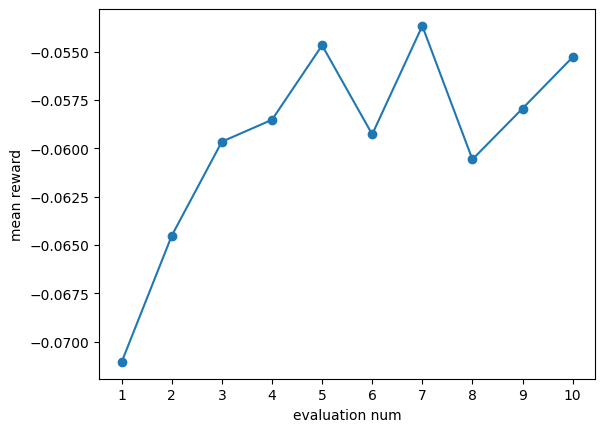

In [12]:
plt.plot(np.arange(1,evals+1,1), mean_rewards, marker="o")
plt.xlabel("evaluation num")
plt.ylabel("mean reward")
plt.xticks(np.arange(1,11,1))
plt.show()

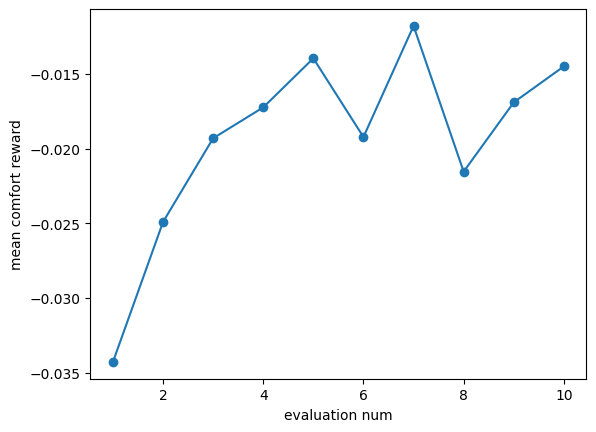

In [11]:
plt.plot(np.arange(1, evals+1, 1), mean_comforts, marker="o")
plt.xlabel("evaluation num")
plt.ylabel("mean comfort reward")
plt.xticks(np.arange(1,11,1))
plt.show()

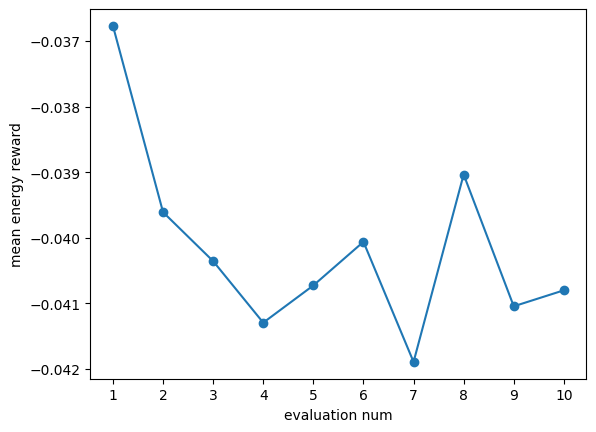

In [13]:
plt.plot(np.arange(1,evals+1,1), mean_energys, marker="o")
plt.xlabel("evaluation num")
plt.ylabel("mean energy reward")
plt.xticks(np.arange(1,11,1))
plt.show()